## Phiên bản được viết bằng Numpy

In [15]:
import os
import sys
sys.path.append('Src')
from Src import func as func

import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import as_strided

import random
import math
import time

In [ ]:
os.chdir(r'D:\University\Applied Parallel Programming\APP-project')

### Class Conv2D

In [14]:
def zero_pad(x, pad):
    return np.pad(x, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

def im2col(x, kernel_size, stride):
    H, W, C = x.shape
    k = kernel_size
    s = stride
    out_h = (H - k) // s + 1
    out_w = (W - k) // s + 1

    cols = np.zeros((out_h * out_w, k * k * C))
    for i in range(out_h):
        for j in range(out_w):
            patch = x[i*s:i*s+k, j*s:j*s+k, :].reshape(-1)
            cols[i * out_w + j] = patch
    return cols, out_h, out_w

def col2im(dcols, input_shape, kernel_size, stride, padding):
    H, W, C = input_shape
    H_pad, W_pad = H + 2 * padding, W + 2 * padding
    k = kernel_size
    s = stride
    out_h = (H_pad - k) // s + 1
    out_w = (W_pad - k) // s + 1

    dx_padded = np.zeros((H_pad, W_pad, C))

    for i in range(out_h):
        for j in range(out_w):
            patch = dcols[i * out_w + j].reshape(k, k, C)
            dx_padded[i*s:i*s+k, j*s:j*s+k, :] += patch

    if padding > 0:
        return dx_padded[padding:-padding, padding:-padding, :]
    return dx_padded

class Conv2D_Numpy:
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        limit = 0.1
        # Kernel: (out_ch, k*k*C_in)
        self.kernels = np.random.uniform(-limit, limit, (out_channels, kernel_size * kernel_size * in_channels))
        self.biases = np.random.uniform(-limit, limit, out_channels)

    def forward(self, input_data):
        self.input_data = input_data
        self.input_padded = zero_pad(input_data, self.padding)

        self.cols, self.out_h, self.out_w = im2col(self.input_padded, self.kernel_size, self.stride)
        out = np.dot(self.cols, self.kernels.T) + self.biases  # (N, out_ch)
        return out.reshape(self.out_h, self.out_w, self.out_channels)

    def backward(self, grad_output):
        dout_flat = grad_output.reshape(-1, self.out_channels)  # (N, out_ch)

        self.grad_kernels = np.dot(dout_flat.T, self.cols)  # (out_ch, k*k*C)
        self.grad_biases = np.sum(dout_flat, axis=0)        # (out_ch,)

        dcols = np.dot(dout_flat, self.kernels)  # (N, k*k*C)
        grad_input = col2im(dcols, self.input_data.shape, self.kernel_size, self.stride, self.padding)
        return grad_input

    def step(self, lr):
        self.kernels -= lr * self.grad_kernels
        self.biases -= lr * self.grad_biases

### **Class Relu**

In [16]:
class ReLU_Numpy:
    def forward(self, x):
        self.input = x  # Lưu lại input để backward
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input

### **Class MaxPool2D**

In [18]:
class MaxPool2D_Numpy:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.input = x
        k = self.kernel_size
        s = self.stride
        H, W, C = x.shape

        out_h = (H - k) // s + 1
        out_w = (W - k) // s + 1

        # Create a view of sliding windows
        shape = (out_h, out_w, k, k, C)
        strides = (x.strides[0]*s, x.strides[1]*s, x.strides[0], x.strides[1], x.strides[2])
        windows = as_strided(x, shape=shape, strides=strides)

        # Reshape and get max + argmax
        flat_windows = windows.reshape(out_h, out_w, k*k, C)
        self.max_indices = np.argmax(flat_windows, axis=2)
        self.output = np.max(flat_windows, axis=2)
        return self.output

    def backward(self, d_out):
        H, W, C = self.input.shape
        k = self.kernel_size
        s = self.stride
        out_h, out_w, _ = d_out.shape

        d_input = np.zeros_like(self.input)

        # Tạo toàn bộ chỉ số i, j, c dưới dạng mảng
        i_idx, j_idx = np.meshgrid(np.arange(out_h), np.arange(out_w), indexing='ij')
        c_idx = np.arange(C)

        # Flatten toàn bộ
        i_idx = i_idx.reshape(-1)
        j_idx = j_idx.reshape(-1)
        max_idx = self.max_indices.reshape(-1, C)  # (N, C)
        d_out_flat = d_out.reshape(-1, C)          # (N, C)

        # Tính lại x/y từ max index
        u = max_idx // k
        v = max_idx % k

        x_idx = i_idx[:, None] * s + u  # (N, C)
        y_idx = j_idx[:, None] * s + v  # (N, C)

        # Broadcast để gán giá trị d_out về đúng vị trí
        for c in range(C):
            np.add.at(d_input[:, :, c], (x_idx[:, c], y_idx[:, c]), d_out_flat[:, c])

        return d_input

### **Conv Block**

In [19]:
class ConvBlock_Numpy:
    def __init__(self, in_channels, out_channels, num_convs=2, padding=0, stride=1):
        self.convs = []
        self.relus = []

        for _ in range(num_convs):
            conv = Conv2D_Numpy(in_channels, out_channels, kernel_size=3, padding=padding, stride=stride)
            relu = ReLU_Numpy()
            self.convs.append(conv)
            self.relus.append(relu)
            in_channels = out_channels  # chuẩn bị cho conv tiếp theo

        self.pool = MaxPool2D_Numpy(kernel_size=2, stride=2)

    def forward(self, input):
        x = input
        for conv, relu in zip(self.convs, self.relus):
            x = conv.forward(x)
            x = relu.forward(x)
        x = self.pool.forward(x)
        return x

    def backward(self, d_out):
        d_out = self.pool.backward(d_out)
        for conv, relu in zip(reversed(self.convs), reversed(self.relus)):
            d_out = relu.backward(d_out)
            d_out = conv.backward(d_out)
        return d_out

    def step(self, learning_rate):
        for conv in self.convs:
            conv.step(learning_rate)

### **Flatten**

In [20]:
class Flatten_Numpy:
    def forward(self, input):
        self.input_shape = input.shape  # (H, W, C)
        return input.reshape(-1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

### **Fully Connected Layer**

In [21]:
class FullyConnected_Numpy:
    def __init__(self, in_dim, out_dim):
        limit = 0.01
        self.W = np.random.uniform(-limit, limit, (in_dim, out_dim))
        self.b = np.random.uniform(-limit, limit, out_dim)

    def forward(self, x):
        self.input = x  # shape: (in_dim,)
        return np.dot(x, self.W) + self.b  # shape: (out_dim,)

    def backward(self, grad_output):
        # grad_output shape: (out_dim,)
        self.grad_W = np.outer(self.input, grad_output)  # shape: (in_dim, out_dim)
        self.grad_b = grad_output  # shape: (out_dim,)
        grad_input = np.dot(grad_output, self.W.T)  # shape: (in_dim,)
        return grad_input

    def step(self, learning_rate):
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b

### **Relu cho Vector**

In [22]:
class ReLUVector_Numpy:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)

### **Softmax + CrossEntropyLoss**

In [23]:
class Softmax_Numpy:
    def forward(self, x):
        self.input = x
        x_stable = x - np.max(x)  # Chống tràn số
        exps = np.exp(x_stable)
        self.output = exps / np.sum(exps)
        return self.output
    
class CrossEntropyLoss_Numpy:
    def forward(self, pred_probs, target_onehot):
        self.pred_probs = pred_probs
        self.target_onehot = target_onehot
        return -np.sum(target_onehot * np.log(pred_probs + 1e-12))  # tránh log(0)

    def backward(self):
        return self.pred_probs - self.target_onehot

### **Class Cấu Trúc**

In [24]:
class SimpleCNN_Numpy:
    def __init__(self):
        self.block1 = ConvBlock_Numpy(3, 64, num_convs=2, padding=1)
        self.block2 = ConvBlock_Numpy(64, 128, num_convs=2, padding=1)
        self.block3 = ConvBlock_Numpy(128, 256, num_convs=2, padding=1)

        self.flatten = Flatten_Numpy()
        self.fc1 = FullyConnected_Numpy(256 * 4 * 4, 512)
        self.relu_fc1 = ReLUVector_Numpy()
        self.fc2 = FullyConnected_Numpy(512, 10)
        self.softmax = Softmax_Numpy()

### **Train**

In [30]:
def train_numpy(model, train_data, train_labels, epochs=10, learning_rate=0.01,
                mb_size=32, log_filename="training_log_numpy.csv", detail_log_filename="details_log_numpy.csv"):

    np.random.seed(0)
    cross_entropy = CrossEntropyLoss_Numpy()
    n_samples = train_data.shape[0]
    indices = np.arange(n_samples)

    for epoch in range(epochs):
        start_epoch = time.time()
        total_loss = 0.0
        correct = 0

        conv2d_time = relu_time = maxpool_time = flatten_time = fc_time = softmax_time = 0.0

        
        np.random.shuffle(indices)
        train_data_shuffled = train_data[indices]
        train_labels_shuffled = train_labels[indices]

        full_batch_count = n_samples // mb_size
        for i in range(full_batch_count):
            start = i * mb_size
            end = start + mb_size
            X_batch = train_data_shuffled[start:end]
            y_batch = train_labels_shuffled[start:end]

            for x, target in zip(X_batch, y_batch):
                ## ====== FORWARD ======
                out = x
                for conv, relu in zip(model.block1.convs, model.block1.relus):
                    t0 = time.time(); out = conv.forward(out); t1 = time.time(); conv2d_time += t1 - t0
                    t0 = time.time(); out = relu.forward(out); t1 = time.time(); relu_time += t1 - t0
                t0 = time.time(); out = model.block1.pool.forward(out); t1 = time.time(); maxpool_time += t1 - t0

                for conv, relu in zip(model.block2.convs, model.block2.relus):
                    t0 = time.time(); out = conv.forward(out); t1 = time.time(); conv2d_time += t1 - t0
                    t0 = time.time(); out = relu.forward(out); t1 = time.time(); relu_time += t1 - t0
                t0 = time.time(); out = model.block2.pool.forward(out); t1 = time.time(); maxpool_time += t1 - t0

                for conv, relu in zip(model.block3.convs, model.block3.relus):
                    t0 = time.time(); out = conv.forward(out); t1 = time.time(); conv2d_time += t1 - t0
                    t0 = time.time(); out = relu.forward(out); t1 = time.time(); relu_time += t1 - t0
                t0 = time.time(); out = model.block3.pool.forward(out); t1 = time.time(); maxpool_time += t1 - t0

                t0 = time.time(); out = model.flatten.forward(out); t1 = time.time(); flatten_time += t1 - t0
                t0 = time.time(); out = model.fc1.forward(out); t1 = time.time(); fc_time += t1 - t0
                t0 = time.time(); out = model.relu_fc1.forward(out); t1 = time.time(); relu_time += t1 - t0
                t0 = time.time(); out = model.fc2.forward(out); t1 = time.time(); fc_time += t1 - t0
                t0 = time.time(); pred_probs = model.softmax.forward(out); t1 = time.time(); softmax_time += t1 - t0

                loss = cross_entropy.forward(pred_probs, target)
                total_loss += loss
                if np.argmax(pred_probs) == np.argmax(target):
                    correct += 1

                ## ====== BACKWARD ======
                t0 = time.time(); grad = cross_entropy.backward(); t1 = time.time(); softmax_time += t1 - t0
                t0 = time.time(); grad = model.fc2.backward(grad); t1 = time.time(); fc_time += t1 - t0
                t0 = time.time(); grad = model.relu_fc1.backward(grad); t1 = time.time(); relu_time += t1 - t0
                t0 = time.time(); grad = model.fc1.backward(grad); t1 = time.time(); fc_time += t1 - t0
                t0 = time.time(); grad = model.flatten.backward(grad); t1 = time.time(); flatten_time += t1 - t0

                t0 = time.time(); grad = model.block3.pool.backward(grad); t1 = time.time(); maxpool_time += t1 - t0
                for conv, relu in zip(reversed(model.block3.convs), reversed(model.block3.relus)):
                    t0 = time.time(); grad = relu.backward(grad); t1 = time.time(); relu_time += t1 - t0
                    t0 = time.time(); grad = conv.backward(grad); t1 = time.time(); conv2d_time += t1 - t0

                t0 = time.time(); grad = model.block2.pool.backward(grad); t1 = time.time(); maxpool_time += t1 - t0
                for conv, relu in zip(reversed(model.block2.convs), reversed(model.block2.relus)):
                    t0 = time.time(); grad = relu.backward(grad); t1 = time.time(); relu_time += t1 - t0
                    t0 = time.time(); grad = conv.backward(grad); t1 = time.time(); conv2d_time += t1 - t0

                t0 = time.time(); grad = model.block1.pool.backward(grad); t1 = time.time(); maxpool_time += t1 - t0
                for conv, relu in zip(reversed(model.block1.convs), reversed(model.block1.relus)):
                    t0 = time.time(); grad = relu.backward(grad); t1 = time.time(); relu_time += t1 - t0
                    t0 = time.time(); grad = conv.backward(grad); t1 = time.time(); conv2d_time += t1 - t0

                ## ====== UPDATE ======
                model.fc2.step(learning_rate)
                model.fc1.step(learning_rate)
                model.block3.step(learning_rate)
                model.block2.step(learning_rate)
                model.block1.step(learning_rate)

        ## ====== LOGGING ======
        end_epoch = time.time()
        epoch_time = end_epoch - start_epoch
        accuracy = correct / (full_batch_count * mb_size)
        func.log_training_details(epoch, epochs, epoch_time, n_samples, total_loss / (full_batch_count * mb_size), accuracy, log_filename)
        func.log_details(f"Epoch_{epoch+1}", mb_size, conv2d_time, relu_time, maxpool_time, flatten_time, fc_time, softmax_time, detail_log_filename)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/(full_batch_count * mb_size):.4f} - Acc: {accuracy:.4f} - Time: {epoch_time:.2f}s")
        print(f"    Conv2D: {conv2d_time:.2f}s | ReLU: {relu_time:.2f}s | MaxPool: {maxpool_time:.2f}s | Flatten: {flatten_time:.2f}s | FC: {fc_time:.2f}s | Softmax: {softmax_time:.2f}s\n")

#### **Tiền xử lý**

In [26]:
def preprocess_data(images, labels, num_classes=10):
    # 1. Normalize pixel values (0-255) → (0-1)
    images = images.astype(np.float32) / 255.0

    # 2. Đảm bảo ảnh có shape (H, W, C), nếu đang là (C, H, W), cần chuyển
    if images.shape[1] == 3:  # Nếu là (N, C, H, W), chuyển về (N, H, W, C)
        images = images.transpose(0, 2, 3, 1)

    # 3. One-hot encoding label
    onehot = np.zeros((labels.shape[0], num_classes), dtype=np.float32)
    onehot[np.arange(labels.shape[0]), labels] = 1.0

    return images, onehot

In [28]:
X_train, y_train, X_test, y_test = func.load_cifar10_data()
X_train, y_train = preprocess_data(X_train, y_train, num_classes=10)
X_test, y_test = preprocess_data(X_test, y_test, num_classes=10)

In [31]:
model = SimpleCNN_Numpy()
train_numpy(
    model,
    X_train[:10],  # train thử 10 mẫu đầu
    y_train[:10],
    epochs=1,        # train thử 1 epoch
    learning_rate=0.01,
    mb_size=2,
    log_filename="Data/log/training_log_numpy_10.csv",
    detail_log_filename="Data/log/details_log_numpy_10.csv"
)

Epoch 1/1 - Loss: 2.3670 - Acc: 0.1000 - Time: 0.82s
    Conv2D: 0.45s | ReLU: 0.02s | MaxPool: 0.05s | Flatten: 0.00s | FC: 0.12s | Softmax: 0.00s



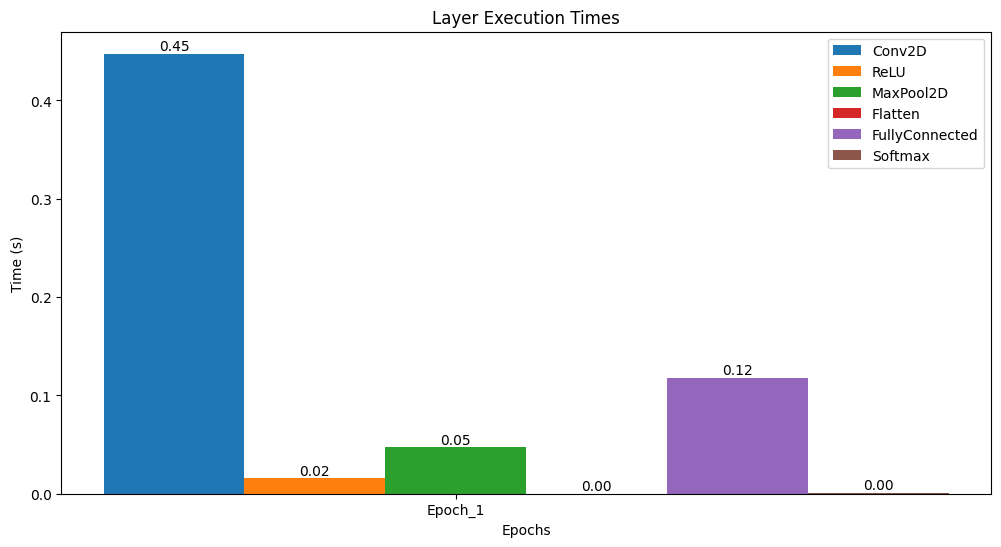

In [32]:
func.plot_details("Data/log/details_log_numpy_10.csv")

In [33]:
model = SimpleCNN_Numpy()
train_numpy(
    model,
    X_train,
    y_train,
    epochs=1,        # train thử 1 epoch
    learning_rate=0.01,
    mb_size=64,
    log_filename="Data/log/training_log_numpy_50000.csv",
    detail_log_filename="Data/log/details_log_numpy_50000.csv"
)

Epoch 1/1 - Loss: 1.5677 - Acc: 0.4268 - Time: 4140.36s
    Conv2D: 2285.49s | ReLU: 62.31s | MaxPool: 214.90s | Flatten: 0.47s | FC: 602.13s | Softmax: 2.27s



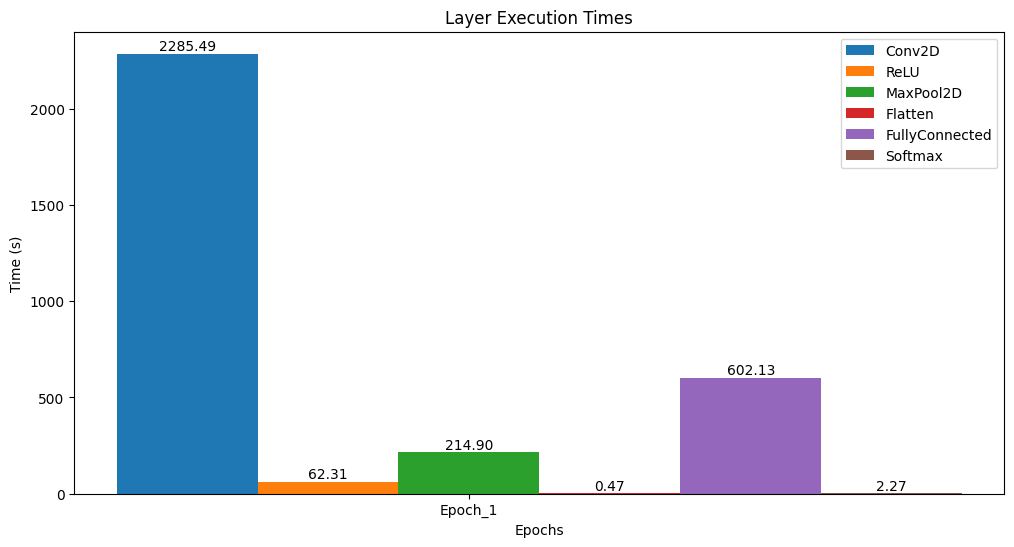

In [34]:
func.plot_details("Data/log/details_log_numpy_50000.csv")

In [37]:
model_10 = SimpleCNN_Numpy()
train_numpy(
    model_10,
    X_train,
    y_train,
    epochs=10,        # train thử 10 epoch
    learning_rate=0.01,
    mb_size=64,
    log_filename="Data/log/training_log_numpy_50000_10.csv",
    detail_log_filename="Data/log/details_log_numpy_50000_10.csv"
)

Epoch 1/10 - Loss: 1.5688 - Acc: 0.4276 - Time: 3955.16s
    Conv2D: 2150.68s | ReLU: 60.42s | MaxPool: 211.00s | Flatten: 0.49s | FC: 601.30s | Softmax: 2.22s

Epoch 2/10 - Loss: 1.2191 - Acc: 0.5725 - Time: 3972.91s
    Conv2D: 2157.70s | ReLU: 61.66s | MaxPool: 208.55s | Flatten: 0.48s | FC: 608.88s | Softmax: 2.19s

Epoch 3/10 - Loss: 1.1614 - Acc: 0.5986 - Time: 4122.75s
    Conv2D: 2238.02s | ReLU: 64.98s | MaxPool: 218.90s | Flatten: 0.50s | FC: 627.25s | Softmax: 2.30s

Epoch 4/10 - Loss: 1.1906 - Acc: 0.5917 - Time: 3849.41s
    Conv2D: 2093.83s | ReLU: 59.97s | MaxPool: 201.69s | Flatten: 0.48s | FC: 584.81s | Softmax: 2.21s

Epoch 5/10 - Loss: 1.2691 - Acc: 0.5655 - Time: 3834.90s
    Conv2D: 2080.71s | ReLU: 60.69s | MaxPool: 202.99s | Flatten: 0.48s | FC: 585.13s | Softmax: 2.05s

Epoch 6/10 - Loss: 1.3870 - Acc: 0.5246 - Time: 3880.39s
    Conv2D: 2101.04s | ReLU: 59.75s | MaxPool: 201.89s | Flatten: 0.41s | FC: 598.45s | Softmax: 2.19s

Epoch 7/10 - Loss: 1.5206 - Acc: 0